In [2]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import pickle

In [3]:
def getDate(filename):
    match_str = re.search(r'\d{4}-\d{2}-\d{2}',filename)
    try:
        return datetime.datetime.strptime(match_str.group(), '%Y-%m-%d').date()
    except ValueError:
        return None

In [4]:
def cleanColumn(name):
    name = name.upper()
    clean_name = re.sub(r'[^a-zA-Z0-9_]', '', name)
    clean_name = clean_name.replace('\n', ' ')
    if clean_name == 'SHELTERNFI':
        clean_name = 'SHELTER'
    if clean_name == 'PROTECTIONCP':
        clean_name = 'PC_CP'
    if clean_name == 'PROTECTIONGBV':
        clean_name = 'PC_GBV'
    if clean_name == 'PROTECTIONMA':
        clean_name = 'PC_MA'
    if clean_name == 'TOTALREACHED':
        clean_name = 'PEOPLEREACHED'
    return clean_name

In [5]:
#using csv and xlsx
csv_dir = 'ukraine_data_excel'


In [6]:
#using xlsx
sheet1_df = []
sheet2_df = []
sheet3_df = []

In [7]:
#using xlsx
for filename in os.listdir(csv_dir):
  if filename.endswith('.xlsx'):
    file_path = os.path.join(csv_dir,filename)
    excel_df = pd.ExcelFile(file_path)
    files_date = getDate(filename)
    for sheet in excel_df.sheet_names:
      df = pd.read_excel(excel_df,sheet_name=sheet)
      df.columns = [cleanColumn(col) for col in df.columns]
      df['DATE'] = files_date
      if sheet == 'Num_of_Orgs_by_Oblast':
        sheet1_df.append(df)
      elif sheet == 'People_Reached_by_Oblast':
        sheet2_df.append(df)
      elif sheet == 'UDE_Inputs':
        sheet3_df.append(df)

In [8]:
combined_sheet1 = pd.concat(sheet1_df, keys=[str(df['DATE'].iloc[0]) for df in sheet1_df])
res_sheet1 = combined_sheet1.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
merged_sheet1 = pd.merge(res_sheet1, combined_sheet1[['ADMIN1_ID', 'DATE', 'OBLAST']], on=['ADMIN1_ID', 'DATE'], how='left')

C:\Users\rober\AppData\Local\Temp\ipykernel_20000\3247654741.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_sheet1 = combined_sheet1.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()


In [9]:
combined_sheet2 = pd.concat(sheet2_df, keys=[str(df['DATE'].iloc[0]) for df in sheet2_df])
res_sheet2 = combined_sheet2.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
columns_to_merge = ['ADMIN1_ID', 'DATE'] 
merged_sheet2 = pd.merge(combined_sheet2[combined_sheet2.columns.to_list()], res_sheet2[columns_to_merge] , on=['ADMIN1_ID', 'DATE'], how='right')

C:\Users\rober\AppData\Local\Temp\ipykernel_20000\4092371189.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_sheet2 = combined_sheet2.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()


In [10]:
merged_sheet2.head()

,OBLAST,ADMIN1_ID,EDUCATION,FSL,GENERALPROTECTION,CP,GBV,MINEACTION,PROTECTIONTOTAL,HEALTH,MPC,NUTRITION,SHELTER,WASH,PEOPLEREACHED,DATE,ADM1_ID
0,Vinnytska,UA05,2800.0,7900.0,11200.0,100.0,100.0,500.0,11900.0,4600.0,91200.0,NaN,15800.0,2300.0,91200.0,2022-04-28,NaN
1,Vinnytska,UA05,2800.0,14300.0,9600.0,100.0,4100.0,500.0,14300.0,4600.0,113000.0,NaN,16200.0,2300.0,113000.0,2022-05-06,NaN
2,Vinnytska,UA05,4900.0,15500.0,11400.0,200.0,4100.0,500.0,16300.0,9900.0,138800.0,NaN,17500.0,3700.0,138800.0,2022-05-12,NaN
3,Vinnytska,UA05,9000.0,17500.0,NaN,500.0,6100.0,500.0,20300.0,23200.0,140600.0,NaN,17500.0,3700.0,140600.0,2022-05-19,NaN
4,Vinnytska,UA05,11500.0,17600.0,NaN,4400.0,6200.0,700.0,25600.0,23300.0,216600.0,NaN,21700.0,3800.0,216600.0,2022-05-26,NaN


In [11]:
merged_sheet2.shape

(675, 17)

In [12]:
merged_sheet2.fillna(0,inplace=True)
merged_sheet2.drop(columns=['ADM1_ID'],inplace=True)

In [13]:
merged_sheet1.isna().any().any()

False

In [14]:
combined_sheet3 = pd.concat(sheet3_df, keys=[str(df['DATE'].iloc[0]) for df in sheet3_df])
res_sheet3 = combined_sheet3.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
merged_sheet3 = pd.merge(res_sheet3, combined_sheet3[['ADMIN1_ID', 'DATE', 'OBLAST']], on=['ADMIN1_ID', 'DATE'], how='left')

C:\Users\rober\AppData\Local\Temp\ipykernel_20000\2370811461.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_sheet3 = combined_sheet3.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()


In [15]:
#Num_of_Orgs_by_Oblast
merged_sheet1.iloc[20:35]

,ADMIN1_ID,DATE,CCCM,CCS,ETC,EDUCATION,FSL,HEALTH,MPC,NUTRITION,PROTECTIONTOTAL,PC_CP,PC_GBV,PC_MA,PC_PC,SHELTER,WASH,TOTAL,LOGISTICS,OBLAST
20,UA05,2022-09-22,2.0,1.0,0.0,4.0,20.0,13.0,6.0,0.0,0.0,4.0,3.0,3.0,0.0,7.0,9.0,58.0,0.0,Vinnytska
21,UA05,2022-09-29,3.0,1.0,0.0,10.0,34.0,24.0,17.0,0.0,0.0,18.0,7.0,4.0,0.0,23.0,15.0,107.0,0.0,Vinnytska
22,UA05,2022-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Vinnytska
23,UA05,2022-10-13,3.0,1.0,0.0,11.0,35.0,24.0,17.0,0.0,0.0,25.0,16.0,5.0,0.0,23.0,13.0,123.0,0.0,Vinnytska
24,UA05,2022-10-27,3.0,1.0,0.0,13.0,36.0,24.0,17.0,0.0,0.0,25.0,10.0,5.0,0.0,23.0,13.0,119.0,0.0,Vinnytska
25,UA05,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Vinnytska
26,UA05,2022-11-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Vinnytska
27,UA05,2022-12-08,3.0,1.0,0.0,13.0,36.0,27.0,18.0,0.0,0.0,26.0,11.0,7.0,0.0,24.0,13.0,125.0,0.0,Vinnytska
28,UA05,2022-12-22,2.0,1.0,0.0,13.0,36.0,33.0,18.0,0.0,0.0,29.0,11.0,8.0,0.0,24.0,13.0,130.0,0.0,Vinnytska
29,UA05,2023-01-05,3.0,1.0,1.0,17.0,39.0,33.0,19.0,0.0,0.0,33.0,10.0,8.0,0.0,25.0,14.0,138.0,0.0,Vinnytska


In [16]:
#People_Reached_by_Oblast
merged_sheet2.iloc[10:25]

,OBLAST,ADMIN1_ID,EDUCATION,FSL,GENERALPROTECTION,CP,GBV,MINEACTION,PROTECTIONTOTAL,HEALTH,MPC,NUTRITION,SHELTER,WASH,PEOPLEREACHED,DATE
10,Vinnytska,UA05,16793,39158.0,0.0,51426.0,9326.0,99772.0,197230.0,38960.0,227756.0,0,65765.0,391243.0,391243.0,2022-07-28
11,Vinnytska,UA05,16801,39158.0,0.0,51426.0,9326.0,102279.0,199737.0,38960.0,229081.0,0,74073.0,391243.0,391243.0,2022-08-04
12,Vinnytska,UA05,16812,39158.0,0.0,67831.0,21467.0,102669.0,229031.0,38960.0,238079.0,0,84680.0,395394.0,395394.0,2022-08-11
13,Vinnytska,UA05,16824,39158.0,0.0,67831.0,21467.0,102669.0,229031.0,43295.0,238270.0,0,84955.0,395394.0,395394.0,2022-08-18
14,Vinnytska,UA05,18424,39158.0,0.0,67831.0,21467.0,102669.0,229802.0,43295.0,231601.0,0,85408.0,395394.0,395394.0,2022-08-25
15,Vinnytska,UA05,18439,39158.0,0.0,67831.0,21467.0,105178.0,246444.0,88760.0,244098.0,0,103967.0,395394.0,395394.0,2022-09-08
16,Vinnytska,UA05,18442,39158.0,0.0,107050.0,19299.0,105178.0,275036.0,88760.0,231215.0,0,105146.0,395394.0,395394.0,2022-09-15
17,Vinnytska,UA05,18442,39158.0,0.0,107050.0,19299.0,105178.0,275036.0,88760.0,232815.0,0,105223.0,395394.0,395394.0,2022-09-22
18,Vinnytska,UA05,18505,39158.0,0.0,107050.0,19299.0,105178.0,275036.0,88760.0,243513.0,0,107109.0,395394.0,395394.0,2022-09-29
19,Vinnytska,UA05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06


In [17]:
merged_sheet3.iloc[20:35]

,ADMIN1_ID,DATE,PEOPLEREACHED,NUMBEROFORGANISATIONS,OBLAST
20,UA05,2022-09-22,395394,58,Vinnytska
21,UA05,2022-09-29,395394,107,Vinnytska
22,UA05,2022-10-06,449220,125,Vinnytska
23,UA05,2022-10-13,395394,123,Vinnytska
24,UA05,2022-10-27,395394,119,Vinnytska
25,UA05,2022-11-10,449220,125,Vinnytska
26,UA05,2022-11-25,449220,125,Vinnytska
27,UA05,2022-12-08,449220,125,Vinnytska
28,UA05,2022-12-22,449220,130,Vinnytska
29,UA05,2023-01-05,449220,138,Vinnytska


In [18]:
merged_sheet1['OBLAST'].value_counts()

Vinnytska           30
Odeska              30
Chernihivska        30
Chernivetska        30
Cherkaska           30
Khmelnytska         30
Khersonska          30
Kharkivska          30
Ternopilska         30
Sumska              30
Rivnenska           30
Poltavska           30
Mykolaivska         30
Volynska            30
Lvivska             30
Luhanska            30
Kirovohradska       30
Kyivska             30
Ivano-Frankivska    30
Zaporizka           30
Zakarpatska         30
Zhytomyrska         30
Donetska            30
Dnipropetrovska     30
Kyiv                30
Name: OBLAST, dtype: int64

In [19]:
sum(merged_sheet3['PEOPLEREACHED'].value_counts())

750

In [20]:
merged_sheet1['DATE'].dtype

dtype('O')

In [21]:
########### mergedsheet 1 prep for interpolation

In [22]:
# convert date column to string type 
merged_sheet1['DATE'] = merged_sheet1['DATE'].astype(str)
#  the specific date you want to find
specific_date_1006 = '2022-10-06'
specific_date_1125 = '2022-11-25'
specific_date_1110 = '2022-11-10'
# filter the df for rows with the specific date
filtered_values1006 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1006]
filtered_values1110 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1110]
filtered_values1125 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1125]

filtered_values1110

,ADMIN1_ID,DATE,CCCM,CCS,ETC,EDUCATION,FSL,HEALTH,MPC,NUTRITION,PROTECTIONTOTAL,PC_CP,PC_GBV,PC_MA,PC_PC,SHELTER,WASH,TOTAL,LOGISTICS,OBLAST
25,UA05,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Vinnytska
55,UA07,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Volynska
85,UA12,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dnipropetrovska
115,UA14,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donetska
145,UA18,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zhytomyrska
175,UA21,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zakarpatska
205,UA23,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zaporizka
235,UA26,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ivano-Frankivska
265,UA32,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kyivska
295,UA35,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kirovohradska


In [23]:
# replace zero values in the empty tuple to NAN for future linear interpolation of ORGS
filtered_values1006= filtered_values1006.replace(0,np.nan)
filtered_values1110= filtered_values1110.replace(0,np.nan)
filtered_values1125= filtered_values1125.replace(0,np.nan)

In [24]:
#overwrite the old values
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1006] = filtered_values1006
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1110] = filtered_values1110
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1125] = filtered_values1125

In [25]:
########### mergedsheet 2 prep for interpolation

In [26]:
# Convert date column to string type 
merged_sheet2['DATE'] = merged_sheet2['DATE'].astype(str)
# filter the df for rows with the specific date
filtered_values1006_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1006]
filtered_values1110_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1110]
filtered_values1125_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1125]
filtered_values1006_m2

,OBLAST,ADMIN1_ID,EDUCATION,FSL,GENERALPROTECTION,CP,GBV,MINEACTION,PROTECTIONTOTAL,HEALTH,MPC,NUTRITION,SHELTER,WASH,PEOPLEREACHED,DATE
19,Vinnytska,UA05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
46,Volynska,UA07,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
73,Dnipropetrovska,UA12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
100,Donetska,UA14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
127,Zhytomyrska,UA18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
154,Zakarpatska,UA21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
181,Zaporizka,UA23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
208,Ivano-Frankivska,UA26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
235,Kyivska,UA32,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06
262,Kirovohradska,UA35,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2022-10-06


In [27]:
# replace zero values in the empty tuple to NAN for future linear interpolation of People
filtered_values1006_m2 = filtered_values1006_m2.replace(0,np.nan)
filtered_values1110_m2 = filtered_values1110_m2.replace(0,np.nan)
filtered_values1125_m2 = filtered_values1125_m2.replace(0,np.nan)

In [28]:
#overwrite the old values
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1006] = filtered_values1006_m2
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1110] = filtered_values1110_m2
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1125] = filtered_values1125_m2

In [29]:
#check for null values
merged_sheet1.isna().any().any()

True

In [30]:
# check for null values in specific row
merged_sheet1.iloc[26].isna().any()

True

In [31]:
#replace dashed in education and nutrition to 0, maybe nan
merged_sheet2 = merged_sheet2.replace('-',0)
e =merged_sheet2[merged_sheet2['EDUCATION']=='-']
n =merged_sheet2[merged_sheet2['NUTRITION']=='-']
e,n

(Empty DataFrame
 Columns: [OBLAST, ADMIN1_ID, EDUCATION, FSL, GENERALPROTECTION, CP, GBV, MINEACTION, PROTECTIONTOTAL, HEALTH, MPC, NUTRITION, SHELTER, WASH, PEOPLEREACHED, DATE]
 Index: [],
 Empty DataFrame
 Columns: [OBLAST, ADMIN1_ID, EDUCATION, FSL, GENERALPROTECTION, CP, GBV, MINEACTION, PROTECTIONTOTAL, HEALTH, MPC, NUTRITION, SHELTER, WASH, PEOPLEREACHED, DATE]
 Index: [])

In [32]:
#filled null values using linear interpolation
num_of_org_interpolated_df = merged_sheet1.interpolate(method='linear')

In [33]:
num_of_org_interpolated_df.isna().any().any()

False

In [34]:
# rounded all int and float dtypes since interpolation caused floats
num_of_org_interpolated_df = num_of_org_interpolated_df.applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

In [ ]:
num_of_org_interpolated_df.loc[num_of_org_interpolated_df['DATE']==specific_date_1110]

In [ ]:
num_of_org_interpolated_df.sort_values(by=['DATE'])

In [ ]:
num_of_org_interpolated_df.describe()

In [38]:
#filled null values using linear interpolation for merged sheet2
people_reached_interpolated_df = merged_sheet2.interpolate(method='linear')
people_reached_interpolated_df.fillna(method='ffill',inplace=True)

In [39]:
#check for null
people_reached_interpolated_df.isna().any().any()

False

In [40]:
# rounded all int and float dtypes since interpolation caused floats
people_reached_interpolated_df = people_reached_interpolated_df.applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

In [ ]:
people_reached_interpolated_df.loc[people_reached_interpolated_df['DATE']==specific_date_1125]

In [42]:
#NUM OF ORGS
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Oblast column
encoded_oblast = label_encoder.fit_transform(num_of_org_interpolated_df['OBLAST'])
#create copy
num_of_org_df_encoded = num_of_org_interpolated_df.copy()
#Add column and assign values
num_of_org_df_encoded['OBLAST_ENCODED'] = encoded_oblast

In [43]:
#NUM OF ORGS
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Date column
encoded_oblast = label_encoder.fit_transform(num_of_org_df_encoded['DATE'])
#create copy
num_of_org_df_encode = num_of_org_df_encoded.copy()
#Add column and assign values
num_of_org_df_encode['DATE_ENCODED'] = encoded_oblast

In [44]:
#PEOPLE REACHED
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Oblast column
encoded_oblast = label_encoder.fit_transform(people_reached_interpolated_df['OBLAST'])
#create copy
people_reached_df_encoded = people_reached_interpolated_df.copy()
#Add column and assign values
people_reached_df_encoded['OBLAST_ENCODED'] = encoded_oblast

In [45]:
#PEOPLE REACHED
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Date column
encoded_oblast = label_encoder.fit_transform(people_reached_df_encoded['DATE'])
#create copy
people_reached_df_encode = people_reached_df_encoded.copy()
#Add column and assign values
people_reached_df_encode['DATE_ENCODED'] = encoded_oblast

In [46]:
#changing the name of the df
people_reached = people_reached_df_encode
num_of_org = num_of_org_df_encode

In [ ]:
people_reached.sort_values(by=['DATE'])

In [ ]:
people_reached['OBLAST'].unique()

In [74]:
# Creating lists based on geographical location
western_region = ['Vinnytska', 'Volynska', 'Zakarpatska', 'Ivano-Frankivska', 'Lvivska', 'Ternopilska']
northern_region = ['Zhytomyrska', 'Rivnenska', 'Chernihivska', 'Kyiv']
central_region = ['Dnipropetrovska', 'Kyivska', 'Kirovohradska', 'Poltavska', 'Khmelnytska', 'Cherkaska']
eastern_region = ['Donetska', 'Luhanska', 'Kharkivska', 'Sumska']
southern_region = ['Zaporizka', 'Mykolaivska', 'Odeska', 'Khersonska', 'Chernivetska']
dfw = people_reached[people_reached['OBLAST'].isin(western_region)]
dfn = people_reached[people_reached['OBLAST'].isin(northern_region)]
dfc = people_reached[people_reached['OBLAST'].isin(central_region)]
dfe = people_reached[people_reached['OBLAST'].isin(eastern_region)]
dfs = people_reached[people_reached['OBLAST'].isin(southern_region)]


In [108]:
top5_oblast_people_reached = ['Lvivska','Kyiv','Dnipropetrovska','Kharkivska','Zaporizka']
temp = num_of_org[num_of_org['OBLAST'].isin(top5_oblast_people_reached)]
temp

,ADMIN1_ID,DATE,CCCM,CCS,ETC,EDUCATION,FSL,HEALTH,MPC,NUTRITION,...,PC_GBV,PC_MA,PC_PC,SHELTER,WASH,TOTAL,LOGISTICS,OBLAST,OBLAST_ENCODED,DATE_ENCODED
60,UA12,2022-04-28,1.0,1.0,1.0,3.0,31.0,19.0,12.0,2.0,...,4.0,2.0,14.0,10.0,15.0,58.0,0.0,Dnipropetrovska,3,0
61,UA12,2022-05-06,1.0,1.0,1.0,3.0,35.0,22.0,11.0,2.0,...,5.0,2.0,15.0,12.0,15.0,64.0,0.0,Dnipropetrovska,3,1
62,UA12,2022-05-12,1.0,1.0,1.0,3.0,47.0,24.0,10.0,2.0,...,6.0,2.0,19.0,12.0,17.0,75.0,0.0,Dnipropetrovska,3,2
63,UA12,2022-05-19,1.0,1.0,1.0,4.0,42.0,25.0,10.0,2.0,...,6.0,2.0,19.0,12.0,17.0,73.0,0.0,Dnipropetrovska,3,3
64,UA12,2022-05-26,0.0,1.0,1.0,5.0,42.0,28.0,9.0,2.0,...,6.0,4.0,18.0,13.0,18.0,74.0,0.0,Dnipropetrovska,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,UA80,2022-11-10,0.3,1.0,1.0,12.7,42.7,51.3,18.3,3.0,...,16.3,8.7,0.0,11.0,13.3,139.0,1.0,Kyiv,10,25
746,UA80,2022-11-25,0.7,1.0,1.0,13.3,43.3,51.7,20.7,3.0,...,16.7,8.3,0.0,12.0,13.7,143.0,1.0,Kyiv,10,26
747,UA80,2022-12-08,1.0,1.0,1.0,14.0,44.0,52.0,23.0,3.0,...,17.0,8.0,0.0,13.0,14.0,147.0,1.0,Kyiv,10,27
748,UA80,2022-12-22,1.0,1.0,1.0,14.0,44.0,63.0,23.0,3.0,...,17.0,8.0,0.0,13.0,14.0,159.0,1.0,Kyiv,10,28


C:\Users\rober\AppData\Local\Temp\ipykernel_20000\650877304.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = temp.groupby(['OBLAST']).sum()


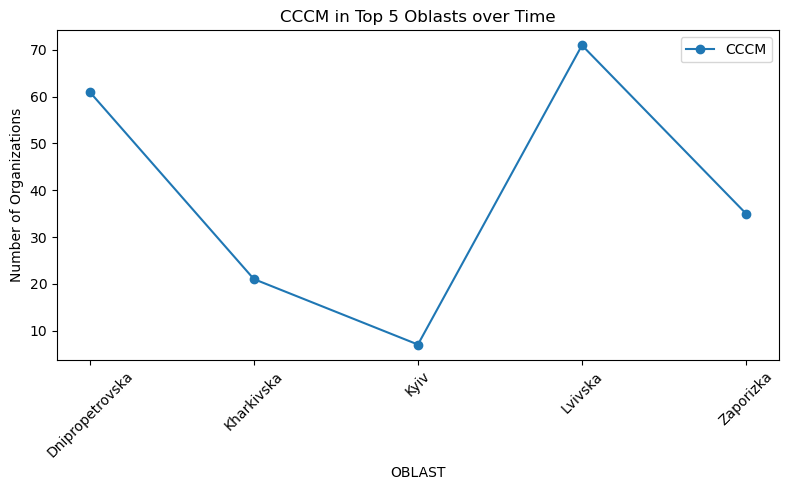

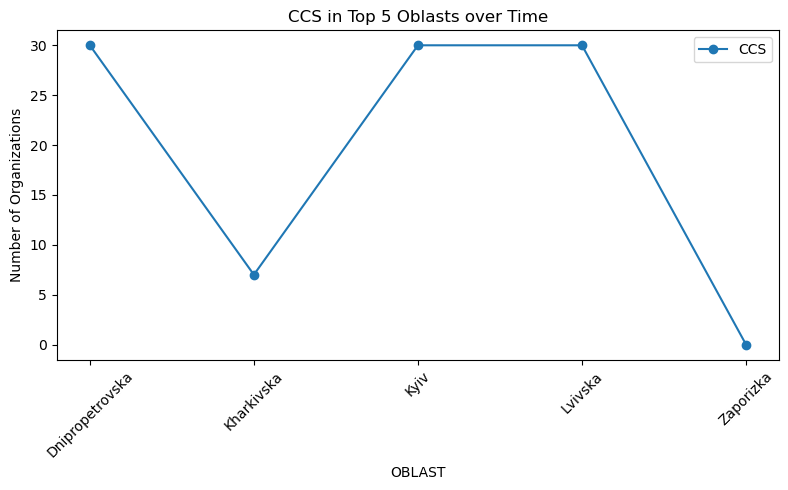

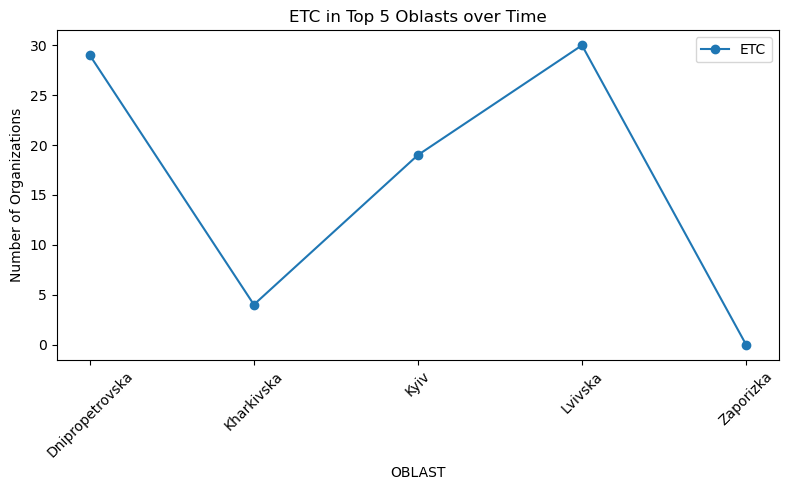

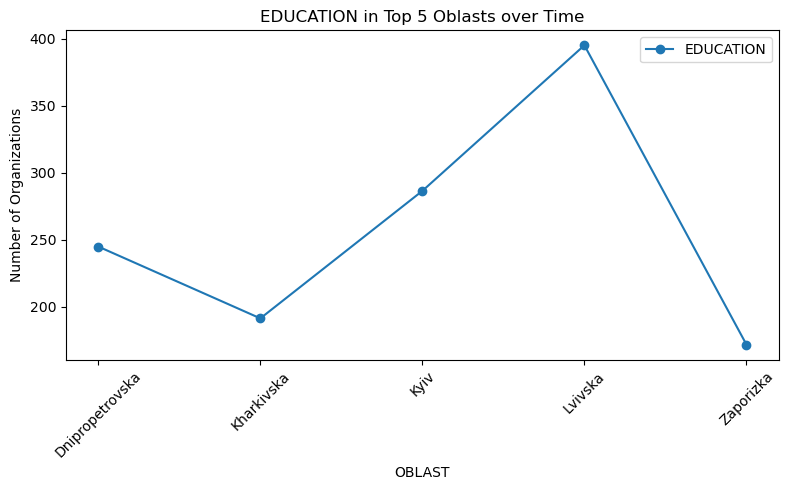

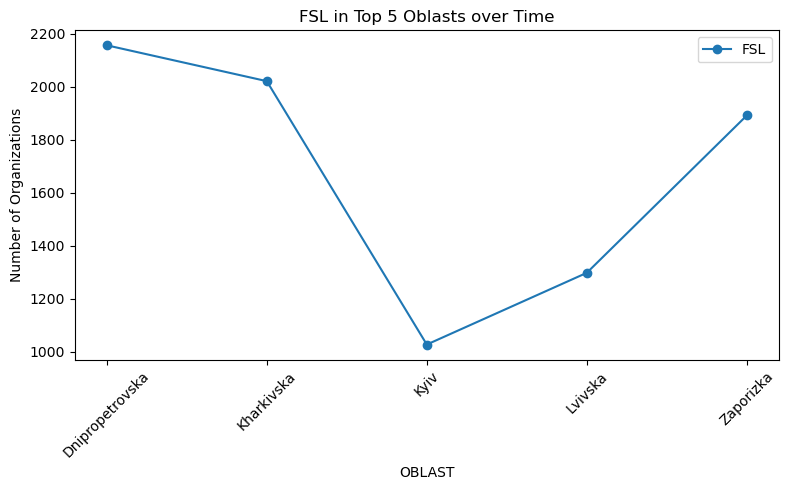

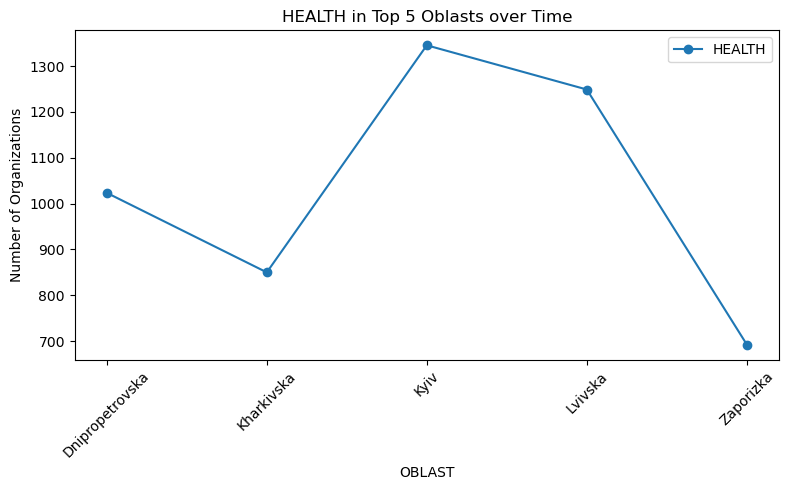

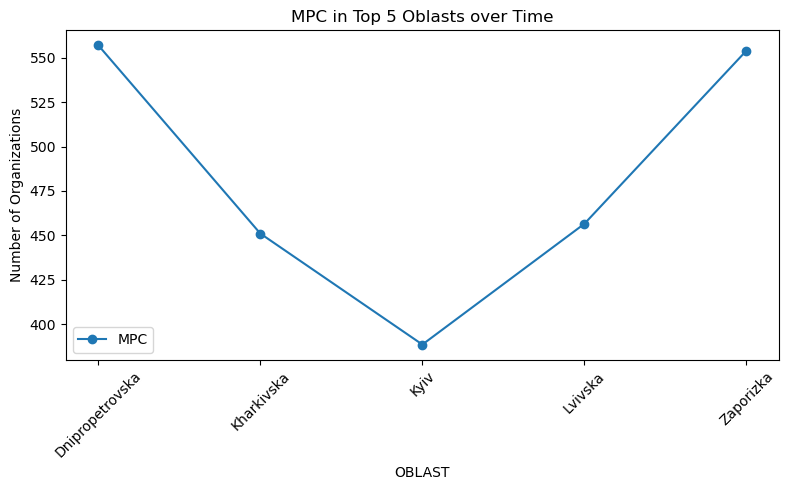

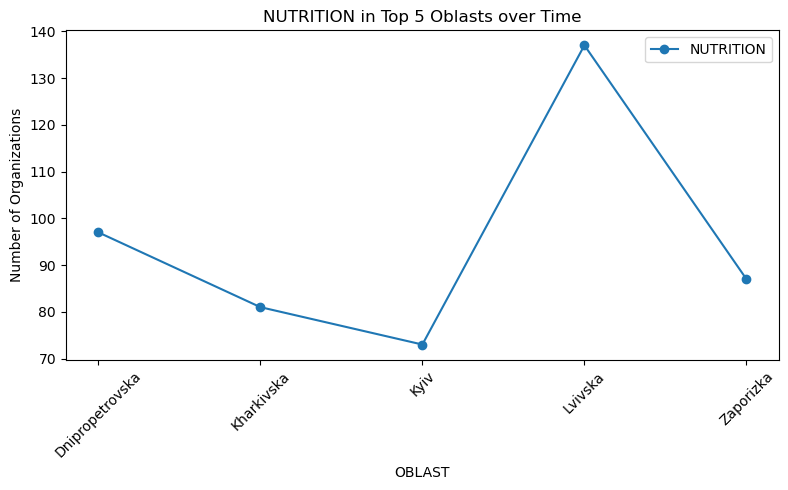

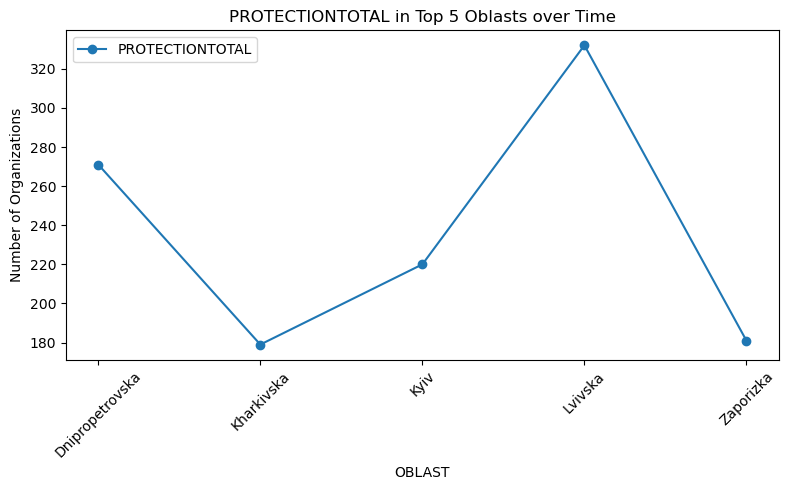

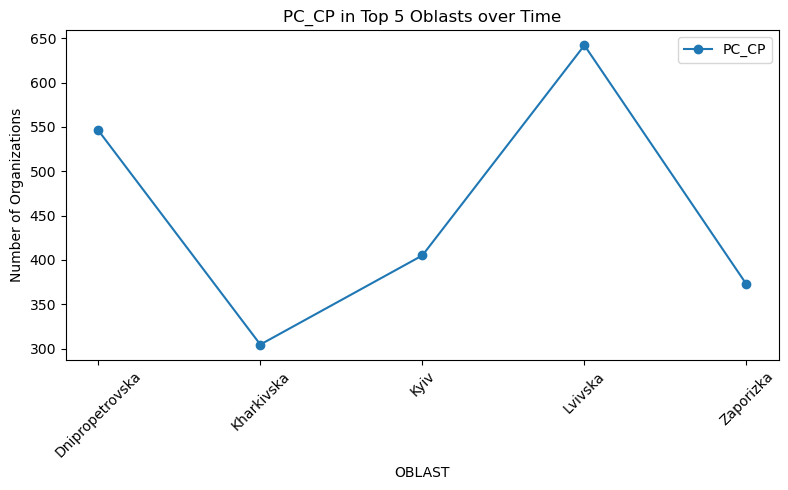

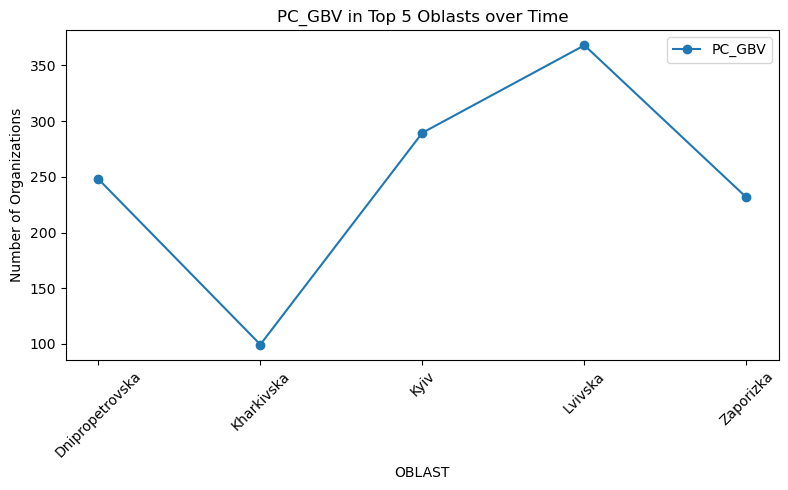

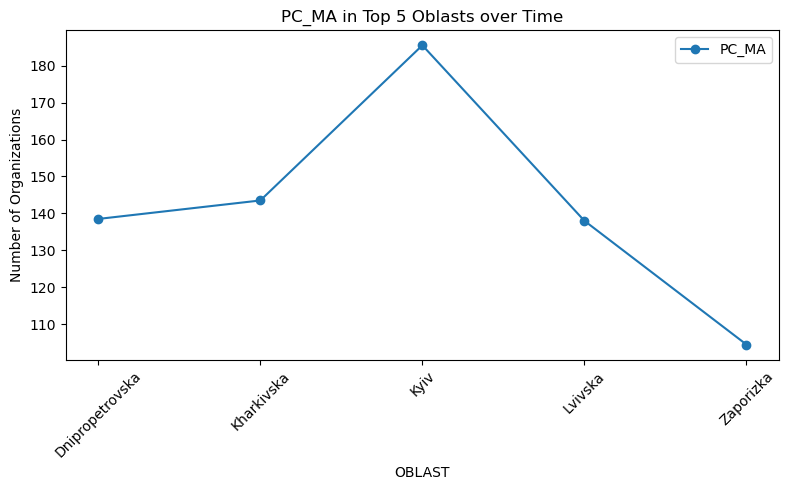

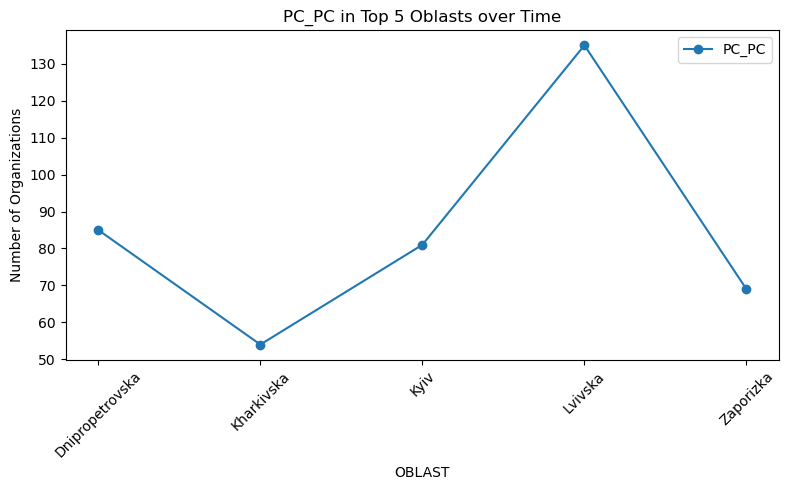

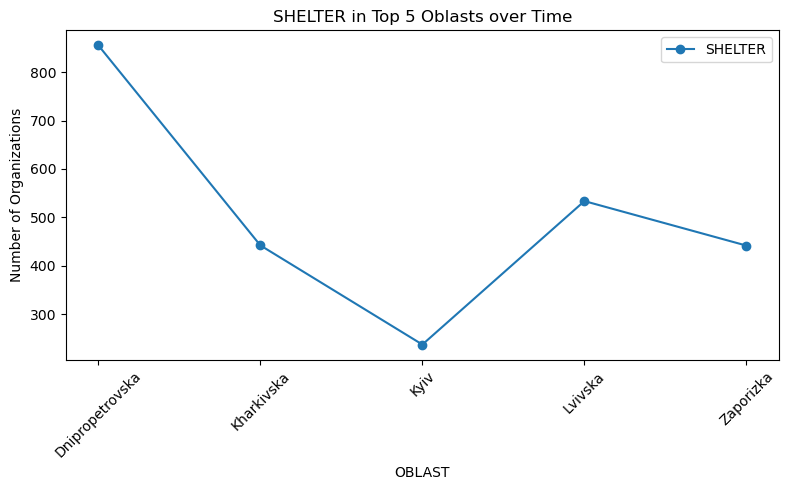

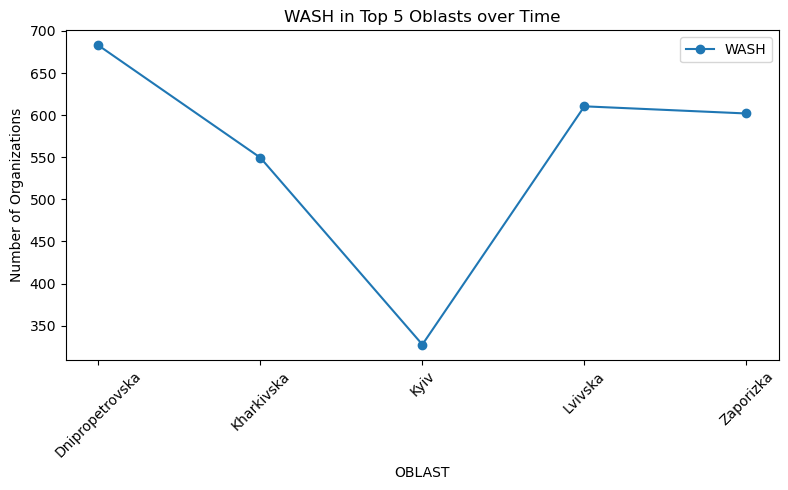

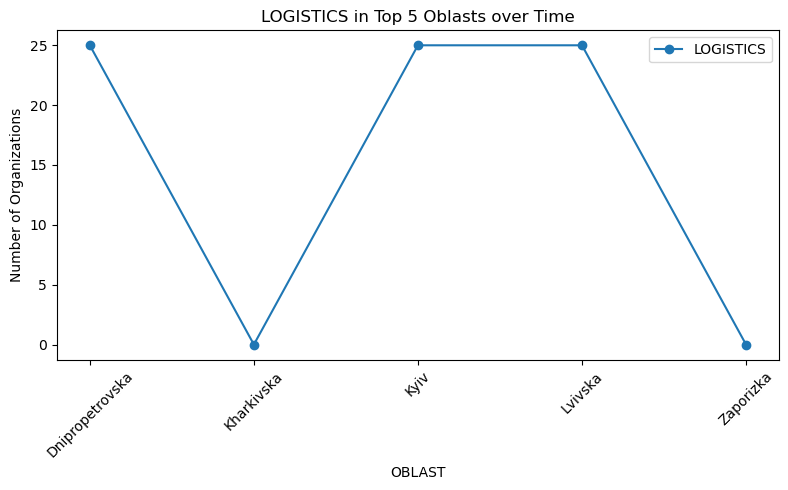

In [126]:

# Group the filtered data by 'DATE' and calculate the sum of each need for the top 5 oblasts
grouped_data = temp.groupby(['OBLAST']).sum()
grouped_data.drop(columns=['OBLAST_ENCODED', 'DATE_ENCODED','TOTAL'], inplace=True)
# Plot each need over time for the top 5 oblasts
for column in grouped_data.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(grouped_data.index, grouped_data[column], marker='o', linestyle='-', label=column)
    plt.title(f'{column} in Top 5 Oblasts over Time')
    plt.xlabel('OBLAST')
    plt.ylabel('Number of Organizations')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [122]:
grouped_data

,CCCM,CCS,ETC,EDUCATION,FSL,HEALTH,MPC,NUTRITION,PROTECTIONTOTAL,PC_CP,PC_GBV,PC_MA,PC_PC,SHELTER,WASH,TOTAL,LOGISTICS,OBLAST_ENCODED,DATE_ENCODED
OBLAST,,,,,,,,,,,,,,,,,,,
Dnipropetrovska,61.0,30.0,29.0,245.0,2157.0,1023.5,557.0,97.0,271.0,546.0,248.0,138.5,85.0,855.5,683.0,4129.0,25.0,90,435
Kharkivska,21.0,7.0,4.0,191.5,2021.5,850.0,451.0,81.0,179.0,304.5,99.5,143.5,54.0,442.0,549.5,3042.0,0.0,180,435
Kyiv,7.0,30.0,19.0,286.5,1026.5,1345.5,388.5,73.0,220.0,405.0,289.5,185.5,81.0,237.0,327.5,2862.0,25.0,300,435
Lvivska,71.0,30.0,30.0,395.0,1297.5,1249.0,456.5,137.0,332.0,642.0,368.0,138.0,135.0,533.5,610.5,3602.0,25.0,390,435
Zaporizka,35.0,0.0,0.0,172.0,1892.0,692.5,554.0,87.0,181.0,372.5,231.5,104.5,69.0,441.5,602.0,2876.0,0.0,690,435


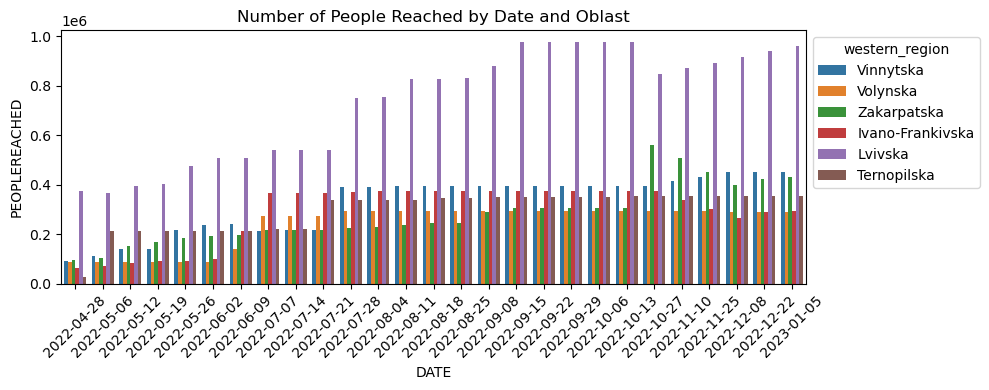

In [89]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfw, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='western_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

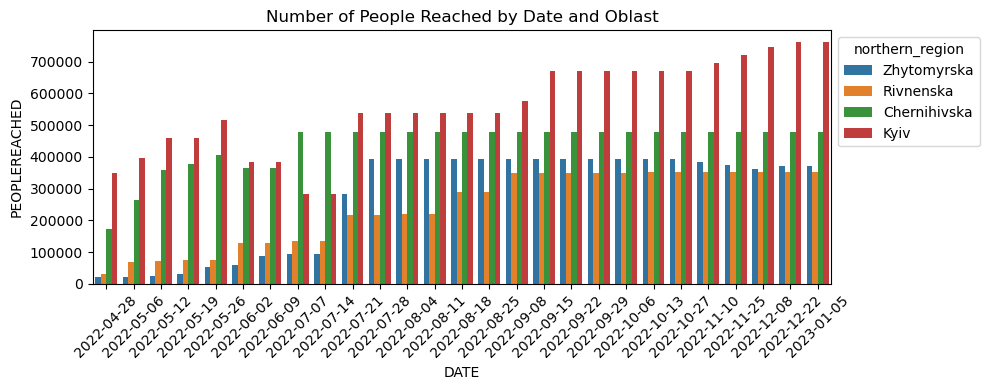

In [84]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfn, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='northern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

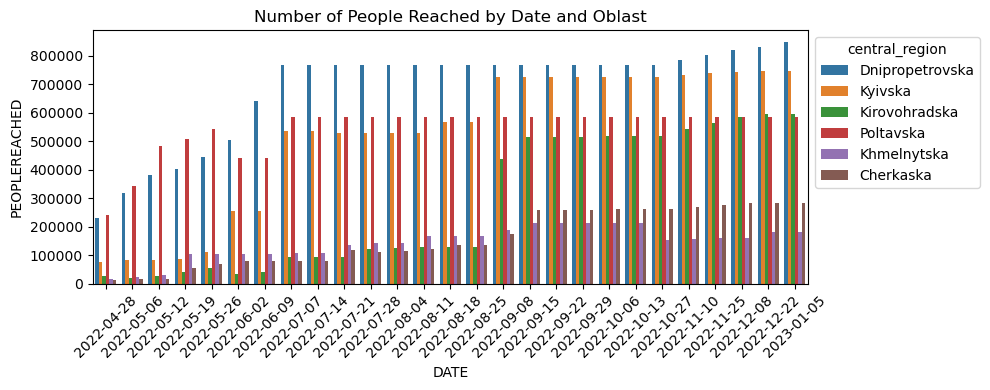

In [85]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfc, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='central_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

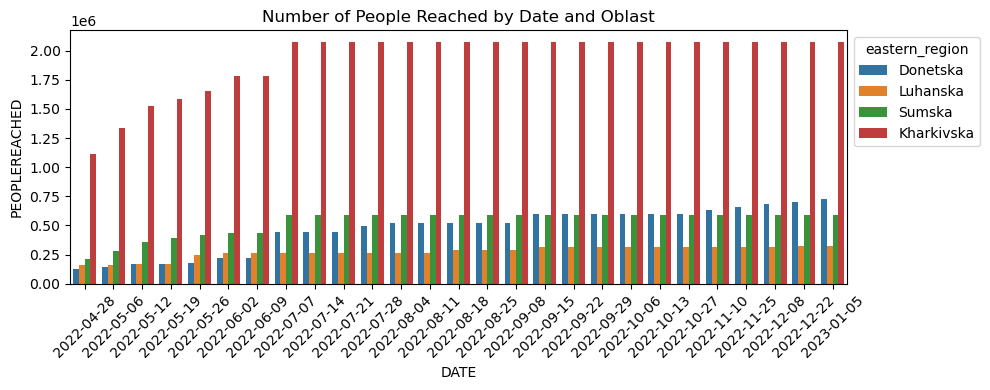

In [86]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfe, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='eastern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

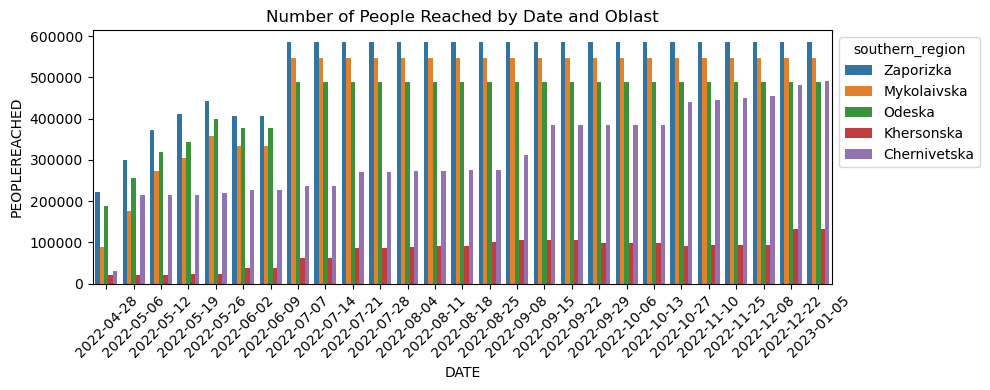

In [87]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfs, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='southern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
num_of_org.iloc[2:5]

,ADMIN1_ID,DATE,CCCM,CCS,ETC,EDUCATION,FSL,HEALTH,MPC,NUTRITION,...,PC_GBV,PC_MA,PC_PC,SHELTER,WASH,TOTAL,LOGISTICS,OBLAST,OBLAST_ENCODED,DATE_ENCODED
2,UA05,2022-05-12,2.0,1.0,1.0,6.0,20.0,18.0,10.0,0.0,...,4.0,2.0,14.0,6.0,9.0,49.0,0.0,Vinnytska,20,2
3,UA05,2022-05-19,2.0,1.0,1.0,6.0,20.0,20.0,10.0,0.0,...,4.0,2.0,14.0,6.0,9.0,50.0,0.0,Vinnytska,20,3
4,UA05,2022-05-26,0.0,1.0,1.0,6.0,20.0,20.0,9.0,0.0,...,4.0,4.0,12.0,7.0,9.0,48.0,0.0,Vinnytska,20,4


In [49]:
people_reached.describe()

,EDUCATION,FSL,GENERALPROTECTION,CP,GBV,MINEACTION,PROTECTIONTOTAL,HEALTH,MPC,NUTRITION,SHELTER,WASH,PEOPLEREACHED,OBLAST_ENCODED,DATE_ENCODED
count,675.000000,6.750000e+02,675.000000,675.00000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,6.750000e+02,6.750000e+02,675.00000,675.000000
mean,13144.528889,3.223601e+05,1079.851852,48951.50963,10075.069630,87349.311111,169513.685926,229081.474815,113779.737037,4289.413333,51623.983704,1.793157e+05,4.422679e+05,12.00000,13.000000
std,15882.226539,4.020878e+05,4596.280587,64356.53692,9379.233431,81629.120822,172213.859271,180738.593741,91701.233400,5480.722386,62037.192128,2.127466e+05,3.730008e+05,7.21645,7.794657
min,0.000000,7.900000e+03,0.000000,0.00000,0.000000,0.000000,800.000000,700.000000,0.000000,0.000000,200.000000,0.000000e+00,1.380000e+04,0.00000,0.000000
25%,1100.000000,6.280800e+04,0.000000,3300.00000,2150.000000,1550.000000,35550.000000,85750.000000,41983.500000,0.000000,12873.500000,2.500000e+04,2.192840e+05,6.00000,6.000000
50%,6482.000000,1.294000e+05,0.000000,22900.00000,7600.000000,85592.000000,133087.000000,211600.000000,101214.000000,2000.000000,31700.000000,1.026610e+05,3.772000e+05,12.00000,13.000000
75%,20400.000000,5.119000e+05,0.000000,73111.50000,15446.350000,117536.000000,235802.500000,345422.500000,159354.500000,7700.000000,69420.000000,2.943350e+05,5.458000e+05,18.00000,20.000000
max,64643.000000,2.070200e+06,37900.000000,372667.00000,54959.000000,352145.000000,974403.000000,761036.000000,523050.000000,22800.000000,505784.000000,1.595189e+06,2.070200e+06,24.00000,26.000000


In [50]:
people_reached.columns

Index(['OBLAST', 'ADMIN1_ID', 'EDUCATION', 'FSL', 'GENERALPROTECTION', 'CP',
       'GBV', 'MINEACTION', 'PROTECTIONTOTAL', 'HEALTH', 'MPC', 'NUTRITION',
       'SHELTER', 'WASH', 'PEOPLEREACHED', 'DATE', 'OBLAST_ENCODED',
       'DATE_ENCODED'],
      dtype='object')

In [51]:
search_result = people_reached[people_reached['EDUCATION'] == '-']
search_result

,OBLAST,ADMIN1_ID,EDUCATION,FSL,GENERALPROTECTION,CP,GBV,MINEACTION,PROTECTIONTOTAL,HEALTH,MPC,NUTRITION,SHELTER,WASH,PEOPLEREACHED,DATE,OBLAST_ENCODED,DATE_ENCODED


In [52]:
search_result = people_reached[people_reached['NUTRITION'] == '-']
search_result.shape

(0, 18)

In [53]:
num_of_org.columns

Index(['ADMIN1_ID', 'DATE', 'CCCM', 'CCS', 'ETC', 'EDUCATION', 'FSL', 'HEALTH',
       'MPC', 'NUTRITION', 'PROTECTIONTOTAL', 'PC_CP', 'PC_GBV', 'PC_MA',
       'PC_PC', 'SHELTER', 'WASH', 'TOTAL', 'LOGISTICS', 'OBLAST',
       'OBLAST_ENCODED', 'DATE_ENCODED'],
      dtype='object')

In [58]:
def grid_search(X_train, X_test, y_train, y_test):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50,100, 200, 300],
        'learning_rate': [0.1, 0.05,0.25, 0.01],
        'max_depth': [3, 4, 5,6],
        'min_samples_leaf': [1, 2, 3, 4],
        'min_samples_split': [2, 3, 4, 5],
        'subsample': [0.6,0.8, 0.9, 1.0],
    }

    # Initialize the model
    gbdt_model = GradientBoostingRegressor()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(gbdt_model, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(X_train, y_train)

   
    best_params = grid_search.best_params_
    print('Best parameters: {0}'.format(best_params))
    best_model = grid_search.best_estimator_
    print('Best model: {0}'.format(best_model))
  
    best_model.fit(X_train, y_train)
    y_gbdt_best_pred = best_model.predict(X_test)
    gbdt_rmse = mean_squared_error(y_test, y_gbdt_best_pred, squared=False)
    gbdt_r2 = r2_score(y_test, y_gbdt_best_pred)

    print('[GBDT] Root Mean Squared Error: {0}'.format(gbdt_rmse))
    print('[GBDT] R2: {0}'.format(gbdt_r2))


In [93]:
#PEOPLE REACHED MODEL 
y_pr = people_reached['PEOPLEREACHED']
X_pr = people_reached.drop(columns=['PEOPLEREACHED','GENERALPROTECTION','OBLAST','DATE','ADMIN1_ID'],axis=1)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, test_size=0.2, random_state=42)

In [94]:
peopleReached = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=6, min_samples_split=8, n_estimators=300, subsample=0.8)
peopleReached.fit(X_train_pr,y_train_pr)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=8,
                          n_estimators=300, subsample=0.8)

In [95]:
pr_rmse = mean_squared_error(y_test_pr, peopleReached.predict(X_test_pr), squared=False)
pr_r2 = r2_score(y_test_pr, peopleReached.predict(X_test_pr))
print('[GBDT] Root Mean Squared Error: {0}'.format(pr_rmse))
print('[GBDT] R2: {0}'.format(pr_r2))

[GBDT] Root Mean Squared Error: 20714.240837895948
[GBDT] R2: 0.9944075695357416


In [96]:
#CCCM
y_cccm = num_of_org['CCCM']
X_cccm = num_of_org.drop(columns=['CCCM','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_cccm, X_test_cccm, y_train_cccm, y_test_cccm = train_test_split(X_cccm, y_cccm, test_size=0.2, random_state=42)

In [97]:
Cccm = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6)
Cccm.fit(X_train_cccm,y_train_cccm)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, subsample=0.6)

In [98]:
cccm_rmse = mean_squared_error(y_test_cccm, Cccm.predict(X_test_cccm), squared=False)
cccm_r2 = r2_score(y_test_cccm, Cccm.predict(X_test_cccm))
print('[GBDT] Root Mean Squared Error: {0}'.format(cccm_rmse))
print('[GBDT] R2: {0}'.format(cccm_r2))

[GBDT] Root Mean Squared Error: 0.42562595397734493
[GBDT] R2: 0.8748396304144401


In [99]:
#EDUCATION
y_etc = num_of_org['ETC']
X_etc = num_of_org.drop(columns=['ETC','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_etc , X_test_etc, y_train_etc, y_test_etc = train_test_split(X_etc, y_etc, test_size=0.2, random_state=42)

In [100]:
etc = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6)
etc.fit(X_train_etc,y_train_etc)

GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=300,
                          subsample=0.6)

In [101]:
etc_rmse = mean_squared_error(y_test_etc, etc.predict(X_test_etc), squared=False)
etc_r2 = r2_score(y_test_etc, etc.predict(X_test_etc))  
print('[GBDT] Root Mean Squared Error: {0}'.format(etc_rmse))
print('[GBDT] R2: {0}'.format(etc_r2))

[GBDT] Root Mean Squared Error: 0.1447550959383035
[GBDT] R2: 0.881225207146045


In [102]:
#CCS
y_ccs = num_of_org['CCS']
X_ccs = num_of_org.drop(columns=['CCS','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_ccs , X_test_ccs, y_train_ccs, y_test_ccs = train_test_split(X_ccs, y_ccs, test_size=0.2, random_state=42)

In [103]:
ccs = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0)
ccs.fit(X_train_ccs,y_train_ccs)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=2, n_estimators=300)

In [104]:
ccs_rmse = mean_squared_error(y_test_ccs, ccs.predict(X_test_ccs), squared=False)
ccs_r2 = r2_score(y_test_ccs, ccs.predict(X_test_ccs))
print('[GBDT] Root Mean Squared Error: {0}'.format(ccs_rmse))
print('[GBDT] R2: {0}'.format(ccs_r2))

[GBDT] Root Mean Squared Error: 0.06860384116985115
[GBDT] R2: 0.9802764093828816


In [105]:
#Total
y_total = num_of_org['TOTAL']
X_total = num_of_org.drop(columns=['TOTAL','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_total , X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [106]:
total = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.6)
total.fit(X_train_total,y_train_total)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=5,
                          n_estimators=300, subsample=0.6)

In [107]:
total_rmse = mean_squared_error(y_test_total, total.predict(X_test_total), squared=False)
total_r2 = r2_score(y_test_total, total.predict(X_test_total))
print('[GBDT] Root Mean Squared Error: {0}'.format(total_rmse))
print('[GBDT] R2: {0}'.format(total_r2))

[GBDT] Root Mean Squared Error: 3.2359692976669936
[GBDT] R2: 0.9940232452435666
